In [1]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

In [371]:
import statsmodels.api as sm
def get_stats(h,e,o):
#     global model,res
    _x = h[e]
    _y = h[o]

    _x1 = sm.add_constant(_x)
    model = sm.OLS(_y,_x1)
    res = model.fit().summary2().tables[1]
    _df = res.loc[e]
    _df['r (corr)'] = np.corrcoef(_x,_y)[1,0]
    return _df

In [372]:
df = pd.read_csv('./data/city_data_elev.csv')
df = df.drop('Unnamed: 0',axis=1)

In [373]:
df['dt'] = pd.to_datetime(df['date'])

In [374]:
df1 = df.set_index('dt')

In [375]:
cols = ['adm2_name','adm1_isocode']

In [376]:
df1['id2'] = df1['adm1_isocode'] +'-'+ df1['adm2_name']

In [377]:
g = df1.groupby(['id2',pd.Grouper(freq='M')])
ds = g[['deaths']].sum()

In [378]:
cc = ['Elevation','country_name','adm1_name','adm2_name']
for c in cc: 
    ds[c] = g[c].first()

ds2 = ds.to_xarray()

ds2[cc] = ds2[cc].max('dt')
ds2 = ds2.set_coords(cc)['deaths']

In [379]:
bo = ds2.loc[{'dt':slice('2018','2021-06')}].count('dt') == 36+6

In [380]:
bo.to_series().describe()

count      493
unique       2
top       True
freq       473
Name: deaths, dtype: object

In [381]:
ds3 = ds2[bo].loc[{'dt':slice('2018','2021-06')}]

In [382]:
ds3['tot_death_2019'] = ds3.loc[{'dt':'2019'}].sum('dt')

In [387]:
# f,ax = plt.subplots(figsize=(5,70))
# ds3['tot_death_2019'].to_series().sort_values().plot.barh()

In [388]:
np.unique(ds3['country_name'])

array(['Brazil', 'Chile', 'Ecuador', 'Paraguay', 'Peru'], dtype=object)

In [460]:
dic

{'Coef.': -0.06370172202708288,
 'Std.Err.': 0.06249640348019448,
 't': -1.0192862065617962,
 'P>|t|': 0.31196549363059817,
 '[0.025': -0.18859081881650847,
 '0.975]': 0.06118737476234269,
 'r (corr)': -0.12737202840512543}

'coef= -0.06 (-0.19,0.06) | P = 0.31'

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/aliaga/mi

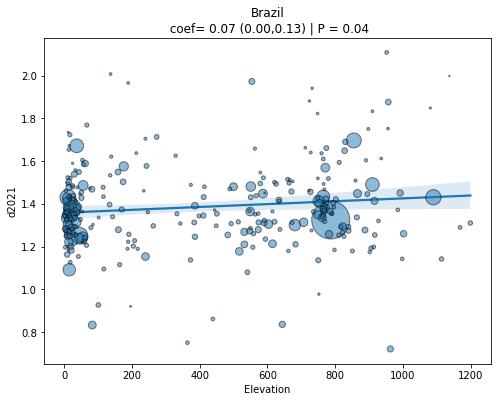

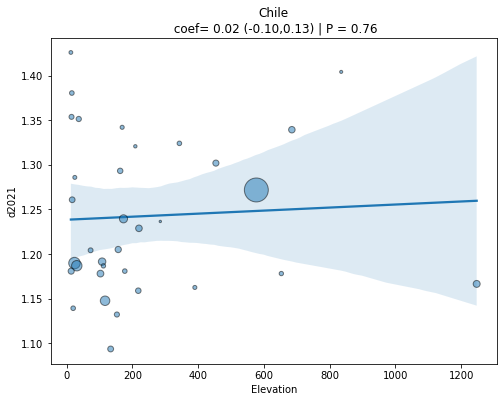

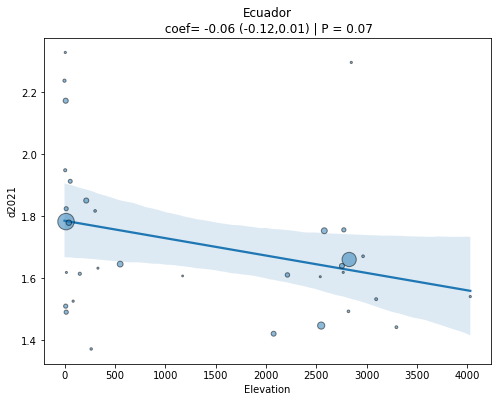

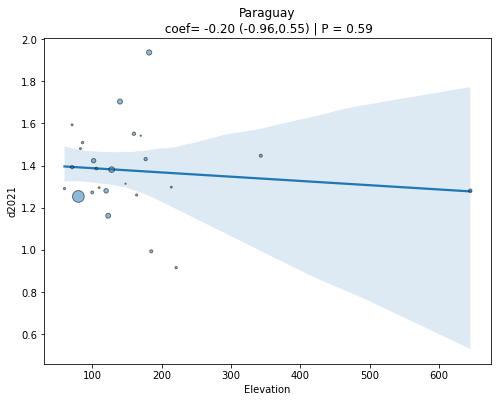

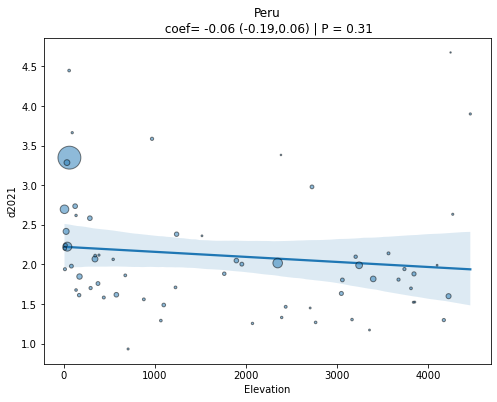

In [466]:
for c in ['Brazil', 'Chile', 'Ecuador', 'Paraguay', 'Peru']: 
    bra = ds3['country_name']==c

    ds4 = ds3[bra]

    ds4['M'] = ds4['dt'].dt.month

    dd=ds4.loc[{'dt':slice('2020-03','2021-06')}]
    d9=ds4.loc[{'dt':'2019'}]

    res = dd.swap_dims({'dt':'M'}).to_series() / d9.swap_dims({'dt':'M'}).reset_coords(drop=True).to_series()
    ds4['d2021'] = res.reset_index().groupby('id2')['deaths'].mean().to_xarray()

    #approx death per mil 
    ds4['approx_pop']=ds4['tot_death_2019']/6*1000

    ff = ds4.reset_coords('d2021')['d2021'].to_dataframe()

    ff = ff.sort_values('approx_pop',ascending=False);

    q1,q2 = ff['d2021'].quantile([.02,.97])

    f1= ff[ff['d2021']<q2]

    _f = f1.dropna(axis=0).copy()

    rr = 'Elev [km]'
    _f[rr] = _f['Elevation']/1000
    stat = get_stats(_f,rr,'d2021')
    stat = stat.to_frame().T
    
    dic = stat.loc[rr].to_dict()
    yy = f"coef= {dic['Coef.']:.2f} ({dic['[0.025']:.2f},{dic['0.975]']:.2f}) | P = {dic['P>|t|']:.2f}"

    f,ax = plt.subplots(figsize=(8,6))
    sns.regplot(data=f1,x='Elevation',y='d2021',scatter=False,ax=ax)
    LL=10000
    ax.scatter(f1['Elevation'],y=f1['d2021'],s=f1['approx_pop']/LL,edgecolor='k',zorder=10,alpha=.5)
    ax.set_title(f'{c}\n {yy}')
    
    

# ax.set_ylim(q1,q2)